In [2]:
import os
import sqlite3
import pandas as pd
import numpy as np
import datetime
import re
from nltk.corpus import stopwords
import nltk
import pickle
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

conn = sqlite3.connect("../../diplom.db")
cur = conn.cursor()

In [3]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from IZVESTIA;""").fetchall()]
graph = [i[0] for text in corpus for i in nltk.bigrams(text) if i[1] == "демократия"]
c = Counter(graph)
adjusting = pd.DataFrame(c.most_common()).rename(columns={0: "Слово", 1: "Количество"})
adjusting["Часть"] = [i[1] for i in nltk.pos_tag(adjusting["Слово"], lang="rus")]
adj = adjusting[adjusting["Часть"].isin(["A=m", "A-PRO=m"])].reset_index(drop=True)
s = adj["Количество"].sum()
adj["Процент"] = round(adj["Количество"]/s*100, 2)

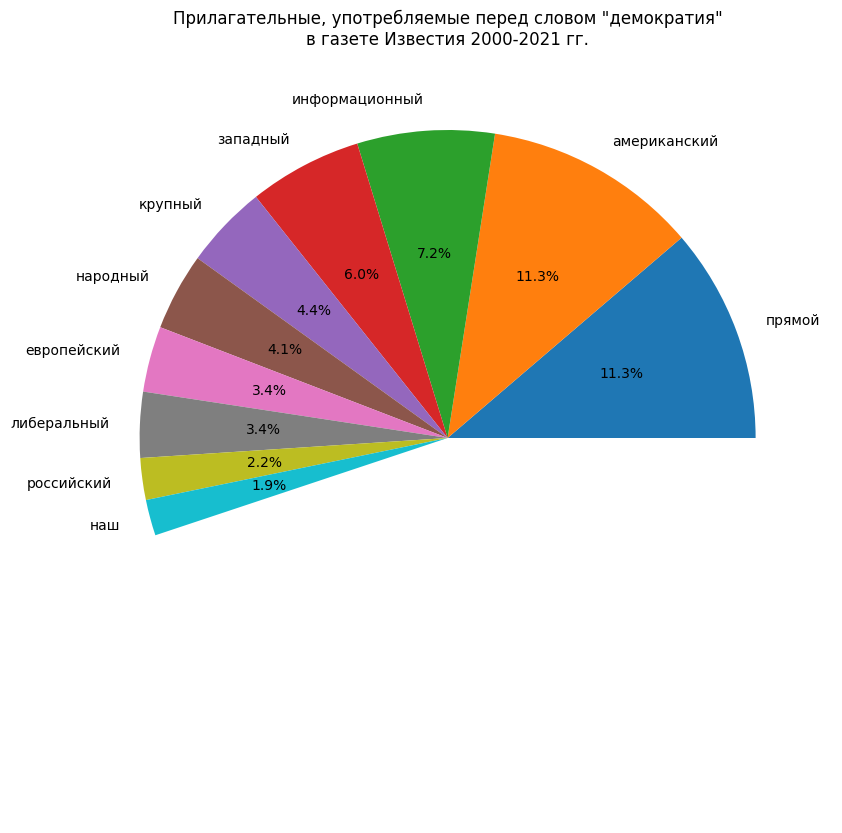

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
rus = adj[["Слово", "Процент"]].head(10)
rus.loc[10, "Слово"] = "Ост."
rus.loc[10, "Процент"] = adj.loc[10:, "Процент"].sum()
wedge, text, procent = ax.pie(rus["Процент"], labels=rus["Слово"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Прилагательные, употребляемые перед словом "демократия"\nв газете Известия 2000-2021 гг.')
fig.savefig("izvestia_adj.png")

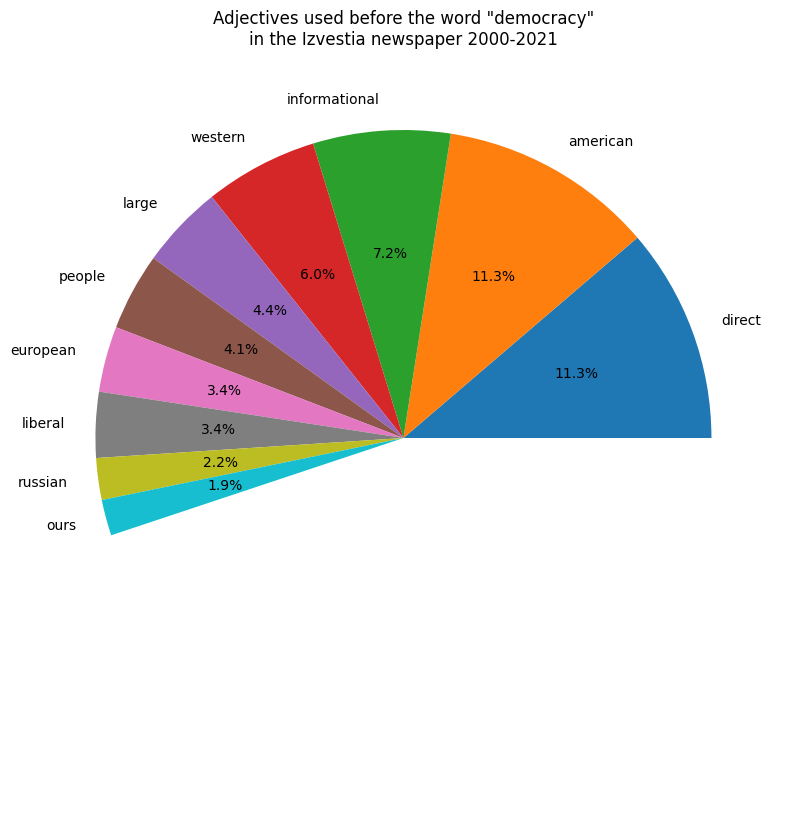

In [5]:
eng = rus.copy()
eng['Word'] = ['direct', 'american', 'informational', 'western', 'large', 'people', 'european', 'liberal', 'russian', 'ours', 'rest']
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
wedge, text, procent = ax.pie(rus["Процент"], labels=eng["Word"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Adjectives used before the word "democracy"\nin the Izvestia newspaper 2000-2021')
fig.savefig("izvestia_adj_en.png")

In [4]:
%%time
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from IZVESTIA""").fetchall()]
model = Word2Vec(corpus, 
                 vector_size=1024,      # embedding vector size
                 min_count=2,
                 window=5)
model.save("izvestia.model")
model.wv.save("izvestia.wordvectors")
model.wv.most_similar('демократия')

CPU times: total: 1h 10min 43s
Wall time: 35min 14s


[('демократический', 0.6029868721961975),
 ('суверенитет', 0.5792021751403809),
 ('социализм', 0.5602093935012817),
 ('идеология', 0.5482956767082214),
 ('устой', 0.5458158254623413),
 ('капитализм', 0.536345362663269),
 ('либерализм', 0.5332401990890503),
 ('единство', 0.532412052154541),
 ('государственность', 0.5315471887588501),
 ('национализм', 0.5263165831565857)]

In [6]:
cur.close()
conn.close()